In [15]:
#Preamble stuff, loading up libraries and convenience functions
import all_data_handler
import pandas
import statsmodels
import statsmodels.api as sm
from statsmodels.formula.api import ols
import itertools
import seaborn as sb
import scipy.stats as ss #For ss.f_oneway() ANOVAs
import re
import matplotlib.pyplot as plt
import numpy as np

adh = all_data_handler.UserData()
per_task_df = pandas.DataFrame(adh.toPandas())
col_list = list(per_task_df)
col_list.remove("user")
col_list.remove("condition")
col_list.remove("task")

#Given the object list of a gesture from the coding, return a list of letters representing normalized 
#values for the objects of the gesture
def tag_object(original):
    #This use of strip is to prevent quotes from messing up regex matches
    original = " ".join(original).strip("\"")
    tags = []
    #Matches robots, robot, bot, bots, etc. 
    robots = re.compile("bot|group|swarm|orange|red", re.I)
    crate = re.compile("crate", re.I)
    targetA = re.compile("area a|box a| a$|to a,|^a$", re.I)
    targetB = re.compile("area b|box b| b$|to b,|^b$", re.I)
    whitespace = re.compile("whitespace|ground|screen|white area", re.I)
    
    toCheck = [(robots, "r"), (crate, "c"), (targetA, "a"), (targetB, "b"), (whitespace, "w")]
    for compiled, tag in toCheck:
        if re.search(compiled, original):
            tags.append(tag)
    return tags

def count_select_taps(participant):
    #Dict of task id to count of taps on robots
    counts = {}
    for task_id in participant["tasks"].keys():
        #Default to no counts of select taps
        counts[task_id] = 0
        events = participant["tasks"][task_id]
        #Flip through all the events
        for event in events:
            if event["event_type"] == "memo":
                #This event is a memo, not a user gesture
                continue
            elif "example" in event.keys() and event["example"] == True:
                #This event is an example, don't count it
                continue
            else:
                #If we have objects, tag them
                if "objects" in event.keys():
                    tags = tag_object(event["objects"])
                    #We have both an event and a set of tags, check if it's a tap on a robot
                    if 'r' in tags and event["event_type"] == "tap":
                        counts[task_id] += 1
    return counts

def count_group_select(participant):
    #Dict of task id to count of taps on robots
    counts = {}
    for task_id in participant["tasks"].keys():
        #Default to no counts of select taps
        counts[task_id] = 0
        events = participant["tasks"][task_id]
        #Flip through all the events
        for event in events:
            if event["event_type"] == "memo":
                #This event is a memo, not a user gesture
                continue
            elif "example" in event.keys() and event["example"] == True:
                #This event is an example, don't count it
                continue
            else:
                #If we have objects, tag them
                if "objects" in event.keys():
                    tags = tag_object(event["objects"])
                    #We have both an event and a set of tags, check if it's a tap on a robot
                    if 'r' in tags and (event["event_type"] == "lasso" or event["event_type"] == "box_select"):
                        counts[task_id] += 1
    return counts

def count_box_select(participant):
    #Dict of task id to count of taps on robots
    counts = {}
    for task_id in participant["tasks"].keys():
        #Default to no counts of select taps
        counts[task_id] = 0
        events = participant["tasks"][task_id]
        #Flip through all the events
        for event in events:
            if event["event_type"] == "memo":
                #This event is a memo, not a user gesture
                continue
            elif "example" in event.keys() and event["example"] == True:
                #This event is an example, don't count it
                continue
            else:
                #If we have objects, tag them
                if "objects" in event.keys():
                    tags = tag_object(event["objects"])
                    #We have both an event and a set of tags, check if it's a tap on a robot
                    if 'r' in tags and event["event_type"] == "box_select":
                        counts[task_id] += 1
    return counts

def count_lasso_select(participant):
    #Dict of task id to count of taps on robots
    counts = {}
    for task_id in participant["tasks"].keys():
        #Default to no counts of select taps
        counts[task_id] = 0
        events = participant["tasks"][task_id]
        #Flip through all the events
        for event in events:
            if event["event_type"] == "memo":
                #This event is a memo, not a user gesture
                continue
            elif "example" in event.keys() and event["example"] == True:
                #This event is an example, don't count it
                continue
            else:
                #If we have objects, tag them
                if "objects" in event.keys():
                    tags = tag_object(event["objects"])
                    #We have both an event and a set of tags, check if it's a tap on a robot
                    if 'r' in tags and event["event_type"] == "lasso":
                        counts[task_id] += 1
    return counts

#Returns a dict of task IDs to count of total events
def count_events(participant):
    counts = {}
    for task_id in participant["tasks"].keys():
        #Default to no counts of select taps
        counts[task_id] = 0
        #Flip through all the events
        events = participant["tasks"][task_id]
        for event in events:
            if event["event_type"] == "memo":
                #This event is a memo, not a user gesture
                continue
            elif "example" in event.keys() and event["example"] == True:
                #This event is an example, don't count it
                continue
            else:
                #Not one of the skip cases, so count it
                counts[task_id] += 1
    return counts

#Prints out the per-condition counts, one entry for each user in that condition
#Also gets the mean and standard deviation for the condition
def user_counts(user_counts):
    per_cond = {}
    #For each user, maintain a running total
    for pid in user_counts.keys():
        #Get their condition
        cond = adh.IdToCondition(pid)[0]
        counts = user_counts[pid].values()
        per_user_total = sum(counts)
        if cond in per_cond.keys():
            per_cond[cond].append(per_user_total)
        else:
            per_cond[cond] = [per_user_total]
    
    for cond in per_cond.keys():
        
        total = sum(per_cond[cond])
        mean = np.mean(per_cond[cond])
        std_dev = np.std(per_cond[cond])
        print cond, per_cond[cond]
        print "total:{} mean:{} std dev:{}".format(total, mean, std_dev)
        print

#Given a dict of user IDs to dicts of task ids to event counts
#return a dict of user IDs to lists of event counts for the common tasks
def get_matched_tasks(counts):
    #Get a list of the task names that every condition has in common
    common_names = []
    for name in adh.taskMap.keys():
        if all(adh.taskMap[name].values()):
            common_names.append(name)
    common_names.sort()

    #dict of user ids to a list of counts, index of counts is task number
    matched_tasks = {}
    for user in counts.keys():
        common_counts = []
        for task in common_names:
            #print user, adh.IdToCondition(user), task, adh.taskNameToNumber(task, user)
            #Get the count at the task number for this common name
            common_counts.append(counts[user][str(adh.taskNameToNumber(task, user))])
        matched_tasks[user] = common_counts
    return matched_tasks

#Given a dict of conditions to lists of samples
#Do an all-pairs 1-way ANOVA on the samples
def all_pairs_f(d):
    for k1, k2 in itertools.combinations(d.keys(), 2):
        print k1, k2
        print ss.f_oneway(d[k1], d[k2])
        print

#Given a dict of users to lists of samples
#Return a dict of conditions to a list of all the samples for users in that condition 
def make_condition_dict(user_samples):
    cond_dict = {}
    for user in user_samples.keys():
        #Get the condition for this user
        cond = adh.IdToCondition(user)[0]
        #If we already have a set of samples, extend it, otherwise, create it
        if cond in cond_dict.keys():
            cond_dict[cond].extend(user_samples[user])
        else:
            cond_dict[cond] = user_samples[user]
    return cond_dict

#Set up dicts of user ids to dicts of task ids to various types of counts
all_select_taps = adh.apply(count_select_taps)
all_group_selects = adh.apply(count_group_select)
all_lassos = adh.apply(count_lasso_select)
all_box = adh.apply(count_box_select)
all_gesture_counts = adh.apply(count_events)

H1: There exists a number of robots beyond which users will transition from treating robots as individuals to interacting with the robots in small groups or as a single large group. 

This transition point will be apparent because of a change in the gesture set that the user uses to interact with the swarm. It is hypothesized that above the transition point, users will be more likely to neglect some subset of the available robots. The user will instead use commands that control the bulk of the robots as a cloud or flock, but may leave some robots unused. For example, the user may switch from selecting robots as individuals to shaping and pushing the swarm the way a child might play with a bug, putting their hand down so the bug goes around or avoids it, touching the back of the bug gently to make it scurry forwards, and so forth, or by shaping the group as if sculpting, with pushing and pinching to "carry" groups around. 

The user may also change how they indicate which robots are to be interacted with. Rather than selecting each robot by clicking on it, they may "paint" over the area containing the robots they want to use, or draw a circle around them. 
The size of the swarm where changes in the user gestures occur will indicate the transition point between interacting with individual robots and interacting with the swarm as a whole. 

This hypothesis would be invalidated by the gestures selected by the user displaying no correlation with the size of the swarm that they are controlling.

In [2]:
#Filter user gesture counts, user tap-as-select counts, and user group select counts to common tasks only
common_select_tap = get_matched_tasks(all_select_taps)
common_group_select = get_matched_tasks(all_group_selects)
common_gesture_counts = get_matched_tasks(all_gesture_counts)

#For each user, get the sum of their gesture use across all the common tasks. This is the user's "verbosity".
#The verbosity is used to normalize the raw counts of gestures so that users that make a lot of gestures don't
#dominate the analysis. 
total_gesture_counts = {k:sum(v) for (k,v) in common_gesture_counts.items()}

#Normalize tap-as-select for matched tasks
#This is a list comprehension that does the norming (divide each task by the appropriate entry in the total counts)
#inside of a dictionary comprehension that operates over all users
norm_select_tap = {k:[float(count)/float(total_gesture_counts[k]) for count in v] for (k,v) in common_select_tap.items()}
#Normalize group select for matched tasks
norm_group_select = {k:[float(count)/float(total_gesture_counts[k]) for count in v] for (k,v) in common_group_select.items()}

#Set up dictionaries by condition for all-pairs ANOVA for tap-as-select and group select
select_tap_by_cond = make_condition_dict(norm_select_tap)
group_select_by_cond = make_condition_dict(norm_group_select)

#And do our ANOVAS
print "Tap as Select"
all_pairs_f(select_tap_by_cond)



Tap as Select
unknown thousand
F_onewayResult(statistic=4.857660764681959, pvalue=0.028806401178702146)

unknown hundred
F_onewayResult(statistic=8.874444350701339, pvalue=0.003295634676882301)

unknown ten
F_onewayResult(statistic=0.47522212088753896, pvalue=0.4914921715791879)

unknown one
F_onewayResult(statistic=2.6306783002182796, pvalue=0.10658684217143713)

thousand hundred
F_onewayResult(statistic=1.0228400919295035, pvalue=0.3132190642039571)

thousand ten
F_onewayResult(statistic=1.788549832548111, pvalue=0.18280936019424932)

thousand one
F_onewayResult(statistic=10.45962892134517, pvalue=0.0014544293123260345)

hundred ten
F_onewayResult(statistic=4.201182723081977, pvalue=0.041862718197988216)

hundred one
F_onewayResult(statistic=13.799628516759492, pvalue=0.00027202826822461256)

ten one
F_onewayResult(statistic=4.503627229070396, pvalue=0.03520618864924477)



For a=0.05, the following pairs of conditions in bold have statistically significant differences in the use of tap as select:

|              | unknown | one    | ten        | hundred     | thousand   | 
| ------------ | ------- | ------ | ---------- | ----------- | ---------- |
| **unknown**  |         | 0.1066 |   0.4915   | **0.0032**  | **0.0288** |   
| **one**      |         |        | **0.0352** | **0.0003**  | **0.0014** |
| **ten**      |         |        |            | **0.0419**  |   0.1828   |
| **hundred**  |         |        |            |             |   0.3132   |
| **thousand** |         |        |            |             |            |

One and ten not differing from unknown is expected. In the one and ten robot case, actions on individual robots do not take up too much time, and the unknown case is like the one robot case in that a single entity is displayed, although it represents more than one robot. 

The differences between thousand and unknown are surprising, since it seemed like a lot of users in the thousand robot case didn't use group selection, but apparently enough did that it is still more like the ten and hundred cases than the one and unknown cases. 

The hundred and ten case, I would have expected to be more similar. 

In [3]:
print "Group Select"
all_pairs_f(group_select_by_cond)

Group Select
unknown thousand
F_onewayResult(statistic=10.817674837981038, pvalue=0.001211720122771659)

unknown hundred
F_onewayResult(statistic=51.10444866800627, pvalue=2.179056890041691e-11)

unknown ten
F_onewayResult(statistic=39.03237249237476, pvalue=2.9852519963238435e-09)

unknown one
F_onewayResult(statistic=nan, pvalue=nan)

thousand hundred
F_onewayResult(statistic=28.89935934050297, pvalue=2.3691725354231207e-07)

thousand ten
F_onewayResult(statistic=18.535993292609703, pvalue=2.7489292452600023e-05)

thousand one
F_onewayResult(statistic=10.817674837981038, pvalue=0.001211720122771659)

hundred ten
F_onewayResult(statistic=1.421140552523716, pvalue=0.2348026467807657)

hundred one
F_onewayResult(statistic=51.10444866800626, pvalue=2.1790568900417192e-11)

ten one
F_onewayResult(statistic=39.03237249237475, pvalue=2.9852519963238435e-09)



/usr/lib/python2.7/dist-packages/scipy/stats/stats.py:2952: RuntimeWarning: invalid value encountered in double_scalars
  f = msb / msw


For a=0.05, the following pairs of conditions in bold have statistically significant differences in the use of group selections:

|              | unknown | one    | ten        | hundred     | thousand   | 
| ------------ | ------- | ------ | ---------- | ----------- | ---------- |
| **unknown**  |         | NaN    | **0.0000** | **0.0000**  | **0.0016** |   
| **one**      |         |        | **0.0000** | **0.0000**  | **0.0016** |
| **ten**      |         |        |            |   0.1801    | **0.0000** |
| **hundred**  |         |        |            |             | **0.0000** |
| **thousand** |         |        |            |             |            |

The reason that unknown and one have an uncomputable ANOVA is that in the common tasks for the one and unknown robot conditions, no group selection gestures were used.

This restriction to the common tasks is because some tasks do not make sense for a single robot, such as forming a square formation, and some do not make sense for an unknown number of robots, such as tasks that single out a specific robot. 

In the next section, I will work with only the ten, hundred, and thousand robot cases, as these cases have all of their tasks in common (but not in common with the one and unknown cases). 



In [4]:
#Convert the dictionary of user id to dictionary of task to count to a simple list of counts
#The list is ordered by task
def tasks_to_list(tasks):
    counts = []
    for key in sorted(tasks.iterkeys()):
        counts.append(tasks[key])
    return counts

#For each user, get the sum of their gesture use across all the tasks. As above, this gets used as verbosity.
total_gesture_counts = {k:sum([count for count in v.values()]) for (k,v) in all_gesture_counts.items()}

all_select_taps
#Convert the dicts of per-task dicts of counts into a dict of ordered list of counts
#The keys at the top level remain the user ids
tap_select_counts = {k:tasks_to_list(v) for (k,v) in all_select_taps.items()}
group_select_counts = {k:tasks_to_list(v) for (k, v) in all_group_selects.items()}

# #Normalize the counts by the user's total gestures
norm_select_tap = {k:[float(count)/float(total_gesture_counts[k]) for count in v] for (k,v) in tap_select_counts.items()}
norm_group_select = {k:[float(count)/float(total_gesture_counts[k]) for count in v] for (k,v) in group_select_counts.items()}

#Set up dictionaries by condition for all-pairs ANOVA for tap-as-select and group select
select_tap_by_cond = make_condition_dict(norm_select_tap)
group_select_by_cond = make_condition_dict(norm_group_select)

#Get rid of the conditions we're not checking (the don't have the same number of samples)
del select_tap_by_cond["one"]
del select_tap_by_cond["unknown"]
all_pairs_f(select_tap_by_cond)



thousand hundred
F_onewayResult(statistic=0.24214754060632215, pvalue=0.622960939579051)

thousand ten
F_onewayResult(statistic=3.9852059977626766, pvalue=0.04665847479025153)

hundred ten
F_onewayResult(statistic=2.399275134994357, pvalue=0.12227501538059789)



Across all tasks, with a=0.05, only thousand differs from ten in the use of taps as a selection gesture. This is likely because with ten robots, tapping each individual is not too difficult, but beyond that, it becomes time-consuming and tedious. I'm surprised ten and hundred don't show a significant difference. 

In [5]:
#Get rid of the conditions we're not checking (the don't have the same number of samples)
del group_select_by_cond["one"]
del group_select_by_cond["unknown"]
all_pairs_f(group_select_by_cond)


thousand hundred
F_onewayResult(statistic=46.93700094454729, pvalue=3.210528401062233e-11)

thousand ten
F_onewayResult(statistic=28.420205547243633, pvalue=1.7326302506804138e-07)

hundred ten
F_onewayResult(statistic=3.4875197834890277, pvalue=0.0626501116426523)



Across all tasks, with a=0.05, hundred and ten both differ from thousand, but not from each other, in the use of group selects as a selection gesture. 

The reason for this is that the use of group selections actually drops off in the thousand robot case compared to the hundred robot case. This is evidence that the user expects commands to be obeyed by all robots, without having to select them first. 


In [18]:
def total_by_condition(by_user):
    counts_by_cond = make_condition_dict(by_user)
    for cond in counts_by_cond.keys():
        print cond
        print "\tTotal: {}".format(sum(counts_by_cond[cond]))
        #These don't make sense because they're broken down by task, so I don't get per-user means
        #print "\tMean: {}".format(np.mean(counts_by_cond[cond]))
        #print "\tStdDev: {}".format(np.std(counts_by_cond[cond]))
        
#Display the total count of group selection gestures per condition
print "\n-- group select, all tasks --"
total_by_condition(group_select_counts)

#Display the total amount of group selection gestures within the common tasks, per condition
print "\n-- group select, common tasks --"
total_by_condition(common_group_select)

#Display the total amount of tap selection gestures per condition
print "\n-- tap select, all tasks --"
total_by_condition(tap_select_counts)

#Display the total amount of tap selection gestures within the common tasks, per condition
print "\n-- tap select, common tasks --"
total_by_condition(common_select_tap)


-- group select, all tasks --
unknown
	Total: 4
thousand
	Total: 112
hundred
	Total: 352
ten
	Total: 428
one
	Total: 12

-- group select, common tasks --
unknown
	Total: 0
thousand
	Total: 60
hundred
	Total: 198
ten
	Total: 220
one
	Total: 0

-- tap select, all tasks --
unknown
	Total: 71
thousand
	Total: 54
hundred
	Total: 87
ten
	Total: 322
one
	Total: 157

-- tap select, common tasks --
unknown
	Total: 48
thousand
	Total: 28
hundred
	Total: 16
ten
	Total: 180
one
	Total: 149


Note that as described above, the thousand robot task has a lower use of group selections than the ten and hundred robot cases, in both the common and in all tasks. It also has a lower use of tap select than the ten and hundred robot cases over all all tasks, but nearly the use of tap to select in the common tasks. That said, 7 and 4 are not huge count differences, given that all other cases have far more tap selects in the common tasks. 

This diminished use of group select for thousand robots across all tasks is what accounts for the statistically significant difference between ten and thousand and between hundred and thousand cases for group selection, while having a statistically insignificant difference between hundred and ten. 


In [ ]:
#Get per-user 

H2: A display which obscures individual robots and displays a cloud or swarm boundary will cause the user to treat the swarm as a whole rather than individuals, which will be apparent because the user will use the same gestures they would use to control a single robot. 

Once the ratio of the size of individual swarm members to the size of the area the swarm is in becomes sufficiently large, displaying the swarm members at the same scale as the map will result in the representation of the swarm members being too small to interact with. This problem will arise at smaller scales if the swarm robots are themselves quite tiny, and some of the available swarm robots are indeed small. Scaling the representation of the robots up, relative to the map, will make the robot representations overlap unrealistically and obscure the map. Instead, we propose that for certain scales of swarms, it makes sense to represent the swarm as the area covered, rather than the locations of the individual robots. This approach has been used successfully for navigation in three dimensions, by developing a controller that causes the individual UAVs to remain within a bounding prism, and allowing the user to control the shape and location of that prism.

Altering how the user interface displays the location of the robots in the swarm will affect the transition point. 

This hypothesis would be invalidated by the gestures selected by the user in the single robot case being dissimilar from those selected in the case where the swarm is displayed as a cloud or covered region. However, some variation is expected in commands for tasks which a swarm can do, which a single robot cannot perform, such as dividing into two groups. 

-----

As seen above, for a=0.05, the following pairs of conditions in bold have statistically significant differences in the use of group selections:

|              | unknown | one    | ten        | hundred     | thousand   | 
| ------------ | ------- | ------ | ---------- | ----------- | ---------- |
| **unknown**  |         | NaN    | **0.0000** | **0.0000**  | **0.0016** |   
| **one**      |         |        | **0.0000** | **0.0000**  | **0.0016** |
| **ten**      |         |        |            |   0.1801    | **0.0000** |
| **hundred**  |         |        |            |             | **0.0000** |
| **thousand** |         |        |            |             |            |

Unknown and one are identical, as they have no use of group selection in the common tasks (which is why the calculation came out to NaN). 

For tap selection:

|              | unknown | one    | ten        | hundred     | thousand   | 
| ------------ | ------- | ------ | ---------- | ----------- | ---------- |
| **unknown**  |         | 0.1066 |   0.4915   | **0.0032**  | **0.0288** |   
| **one**      |         |        | **0.0352** | **0.0003**  | **0.0014** |
| **ten**      |         |        |            | **0.0419**  |   0.1828   |
| **hundred**  |         |        |            |             |   0.3132   |
| **thousand** |         |        |            |             |            |

Unknown and one are not statistically signficantly different, although there is some degree of difference. At least one of the users regularly tapped on the cloud in the unknown robot case as an "attention" signal, which is a sort of selection of the entire group. 

The previous statistical analyses used the total of the user's gestures across all tasks as a measure of their verbosity. Mark Micire's paper used per _task_ normalization, rather than per _user_ normalization. The below analysies are a repeat of the above, except that the gestures are normalized by gesture count per task and not total gestures per user. I don't expect that it will change the results much. 

In [19]:
#Filter user gesture counts, user tap-as-select counts, and user group select counts to common tasks only
common_select_tap = get_matched_tasks(all_select_taps)
common_group_select = get_matched_tasks(all_group_selects)
common_gesture_counts = get_matched_tasks(all_gesture_counts)

#The get_matched_tasks function does a sort on task names, so the lists produced are ordered by task. 
#This means I can get away with zipping the common gesture counts and e.g. the common select taps, and then
#doing the division to normalize in a list comprehension
#Or I could, if it were not for the fact that sometimes the gesture count is 0 (rarely, some users made no gestures)
norm_select_tap = {k:[float(a)/float(b) if a != 0 else 0.0 for a,b in zip(common_select_tap[k], common_gesture_counts[k])] for k in common_select_tap.keys()}
#Normalize group select for matched tasks
norm_group_select = {k:[float(a)/float(b) if a != 0 else 0.0 for a,b in zip(common_group_select[k], common_gesture_counts[k])] for k in common_group_select.keys()}

#For testing 
# for k in common_select_tap.keys():
#     print k
#     print common_group_select[k]
#     print common_gesture_counts[k]
#     print norm_group_select[k]
#     print

#Set up dictionaries by condition for all-pairs ANOVA for tap-as-select and group select
select_tap_by_cond = make_condition_dict(norm_select_tap)
group_select_by_cond = make_condition_dict(norm_group_select)

#And do our ANOVAS
print "Tap as Select"
all_pairs_f(select_tap_by_cond)


Tap as Select
unknown thousand
F_onewayResult(statistic=5.577222739981358, pvalue=0.019276385592448275)

unknown hundred
F_onewayResult(statistic=7.6964308686268055, pvalue=0.006123398182074149)

unknown ten
F_onewayResult(statistic=1.8353598304103607, pvalue=0.17721276637599293)

unknown one
F_onewayResult(statistic=0.3371165780787707, pvalue=0.5622326894557608)

thousand hundred
F_onewayResult(statistic=0.36651781239907794, pvalue=0.5456796105669024)

thousand ten
F_onewayResult(statistic=1.2146251676037936, pvalue=0.27190598611477024)

thousand one
F_onewayResult(statistic=10.427411515786487, pvalue=0.0014785752751878712)

hundred ten
F_onewayResult(statistic=2.5964016313743294, pvalue=0.10887841528272646)

hundred one
F_onewayResult(statistic=13.588890258328336, pvalue=0.00030188601614797734)

ten one
F_onewayResult(statistic=4.329889858594716, pvalue=0.038880302713248306)



For a=0.05, the following pairs of conditions in bold have statistically significant differences in the use of tap selections:

|              | unknown | one    | ten        | hundred     | thousand   | 
| ------------ | ------- | ------ | ---------- | ----------- | ---------- |
| **unknown**  |         | 0.5622 |   0.1772   | **0.0006**  | **0.0193** |   
| **one**      |         |        | **0.0389** | **0.0030**  | **0.0015** |
| **ten**      |         |        |            |   0.1089    |   0.2719   |
| **hundred**  |         |        |            |             |   0.5457   |
| **thousand** |         |        |            |             |            |

One and ten probably don't differ from unknown because they are conditions where the number of robots is small enough that a user can tap on all of the robots. 


In [9]:
print "Group Select"
all_pairs_f(group_select_by_cond)

Group Select
unknown thousand
F_onewayResult(statistic=10.234695939973674, pvalue=0.001631828850498129)

unknown hundred
F_onewayResult(statistic=60.435124868723285, pvalue=5.871514653163783e-13)

unknown ten
F_onewayResult(statistic=47.63591573861913, pvalue=8.695813953501536e-11)

unknown one
F_onewayResult(statistic=nan, pvalue=nan)

thousand hundred
F_onewayResult(statistic=30.237273336840744, pvalue=1.3109879217064968e-07)

thousand ten
F_onewayResult(statistic=19.01097407513412, pvalue=2.1946268839487587e-05)

thousand one
F_onewayResult(statistic=10.23469593997367, pvalue=0.001631828850498129)

hundred ten
F_onewayResult(statistic=1.8055268830162108, pvalue=0.18075611377274647)

hundred one
F_onewayResult(statistic=60.43512486872327, pvalue=5.871514653163783e-13)

ten one
F_onewayResult(statistic=47.63591573861913, pvalue=8.695813953501536e-11)



For a=0.05, the following pairs of conditions in bold have statistically significant differences in the use of group selections:

|              | unknown | one    | ten        | hundred     | thousand   | 
| ------------ | ------- | ------ | ---------- | ----------- | ---------- |
| **unknown**  |         | NaN    | **0.0000** | **0.0000**  | **0.0016** |   
| **one**      |         |        | **0.0000** | **0.0000**  | **0.0016** |
| **ten**      |         |        |            |   0.1808    | **0.0000** |
| **hundred**  |         |        |            |             | **0.0000** |
| **thousand** |         |        |            |             |            |



Unknown doesn't differ from one at all, they both have no uses of group selection, which is why the ANOVA results in NaN. 

I'm not sure how to explain the difference in use of group selection between pretty much all other cases. My expectation would have been that the one and unknown were similar to each other, and that the ten, hundred, and thousand were similar to each other, rather than that e.g. hundred and thousand were very different. 

F: 32.1348371072
p: 1.53536727593e-23


/usr/lib/python2.7/dist-packages/matplotlib/__init__.py:894: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
/usr/lib/python2.7/dist-packages/seaborn/categorical.py:444: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


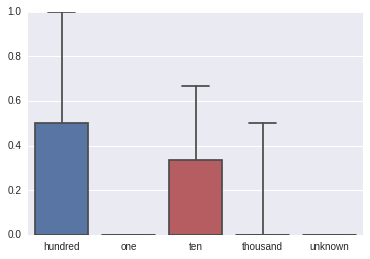

In [10]:
#Following instructions from https://support.minitab.com/en-us/minitab-express/1/help-and-how-to/modeling-statistics/anova/how-to/one-way-anova/interpret-the-results/key-results/
#One-way anova of all groups shows that yes, there is some variation in group means, but doesn't show which groups
f, p = ss.f_oneway(group_select_by_cond["unknown"], group_select_by_cond["one"], group_select_by_cond["ten"], group_select_by_cond["hundred"], group_select_by_cond["thousand"])
print "F: {}".format(f)
print "p: {}".format(p)
#This results in an absurdly low p, so clearly, differences exist

#Get everything into a pandas dataframe and throw it into seaborn to get a boxplot
group_df = pandas.DataFrame.from_dict(group_select_by_cond)

sb.boxplot(data=group_df)


F: 4.83865538278
p: 0.000790252215893


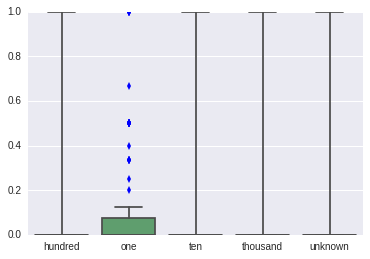

In [11]:
#Following instructions from https://support.minitab.com/en-us/minitab-express/1/help-and-how-to/modeling-statistics/anova/how-to/one-way-anova/interpret-the-results/key-results/
#One-way anova of all groups shows that yes, there is some variation in group means, but doesn't show which groups
f, p = ss.f_oneway(select_tap_by_cond["unknown"], select_tap_by_cond["one"], select_tap_by_cond["ten"], select_tap_by_cond["hundred"], select_tap_by_cond["thousand"])
print "F: {}".format(f)
print "p: {}".format(p)
#This results in an pretty low p, but not as low as for group selection

#Get everything into a pandas dataframe and throw it into seaborn to get a boxplot
tap_df = pandas.DataFrame.from_dict(select_tap_by_cond)

sb.boxplot(data=tap_df)

Normalization reduces the values from raw counts to numbers in the range 0-1. This may squash the visiblity of the differences enough that these graphs are not terribly useful, so I also graphed the raw counts. 

Select tap


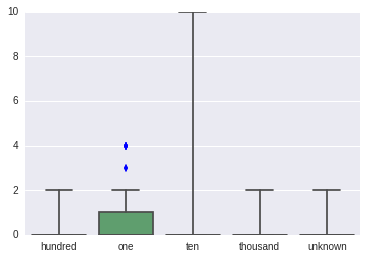

Group select


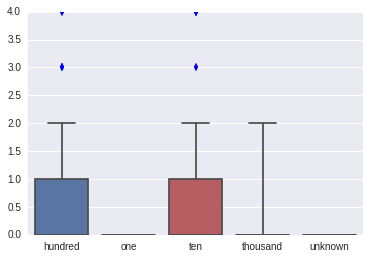

In [13]:
#Raw counts of select taps
print "Select tap"
counts_select_tap = make_condition_dict(common_select_tap)
tap_counts_df = pandas.DataFrame.from_dict(counts_select_tap)
sb.boxplot(data = tap_counts_df)
plt.show()

#Raw counts of group selections
print "Group select"
counts_group_select = make_condition_dict(common_group_select)
group_counts_df = pandas.DataFrame.from_dict(counts_group_select)
sb.boxplot(data = group_counts_df)
plt.show()

